In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata  # Importo griddata
import cmocean #colori per oceanografia
import gsw
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

#definition of the file path
file_path = "C:/Users/Marta/Desktop/PS118_phys_oce1.tab"

#load the data 
df1 = pd.read_csv(file_path, skiprows=4797, nrows=13981, sep='\t')
#data contains the oceanographic data in table form 


#rename the columns
df1.columns = ['Event', 'Date/Time', 'Latitude', 'Longitude', 'Elevation_m', 
               'Depth_m', 'Pressure_dbar',
               'Temperature_C', 'Conductivity_mS_cm', 'Salinity', 'Tpot_C', 
               'Sigma_theta', 'O2', 'O2_sat', 'Attenuation', 'Fluorometer', 'NOBS']


#drop the last 3 columns (by selecting column names)
#data.columns returns a list of all column names; [] it selects only the last 3 
#columns_to_drop contains the names of the last 3 columns i want to remove
columns_to_drop = df1.columns[-3:]

data = df1.drop(columns=columns_to_drop)
#data is updated. Last 3 columns ahve been excluded

#convert the "Date/Time" column to datetime format
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

#create separate "Date" and "Time" columns
data['Date'] = data['Date/Time'].dt.date
data['Time'] = data['Date/Time'].dt.time

#drop the original "Date/Time" column if not needed
data = data.drop(columns=['Date/Time'])


#reorder columns to place 'Date' and 'Time' after 'Event'
data = data[['Event', 'Date', 'Time', 'Latitude', 'Longitude', 'Elevation_m', 
             'Depth_m', 'Pressure_dbar', 'Temperature_C', 'Conductivity_mS_cm', 
             'Salinity', 'Tpot_C', 'Sigma_theta', 'O2', 'O2_sat']]

#print(data.tail())

In [35]:
#meridional averaging
data_mer_av = data.groupby(['Pressure_dbar', 'Longitude'])[['Tpot_C', 'Salinity', 'Sigma_theta']].mean().reset_index()

#extract variables
long = data_mer_av['Longitude'].values
p = data_mer_av['Pressure_dbar'].values
Tpot = data_mer_av['Tpot_C'].values
Salinity = data_mer_av['Salinity'].values
sigma_theta = data_mer_av['Sigma_theta'].values  #density for isolines

In [37]:
#plt.plot(long,'*')

In [39]:
#verifico i mini e i massimi dei dati
#print(np.max(p))
#print(np.max(Tpot))
#print(np.min(Tpot))
#print(np.max(Salinity))
#print(np.min(Salinity))

#verifico i valori massimi e minimi di sigma_theta e se ne manca qualcuno
#print(np.nanmin(sigma_theta))
#print(np.nanmax(sigma_theta)) 

In [41]:
#structured grid
long_grid = [-53.8027, -53.6639, -53.5333, -53.3744, -53.1500, -52.8898, -52.6662, -52.3943]
p_grid = np.linspace(p.min(), p.max(), 3000)  
long_grid, p_grid = np.meshgrid(long_grid, p_grid)

#interpolation in grid
grid_Tpot = griddata((long, p), Tpot, (long_grid, p_grid), method='linear')
grid_Salinity = griddata((long, p), Salinity, (long_grid, p_grid), method='linear')
grid_sigma_theta = griddata((long, p), sigma_theta, (long_grid, p_grid), method='linear')

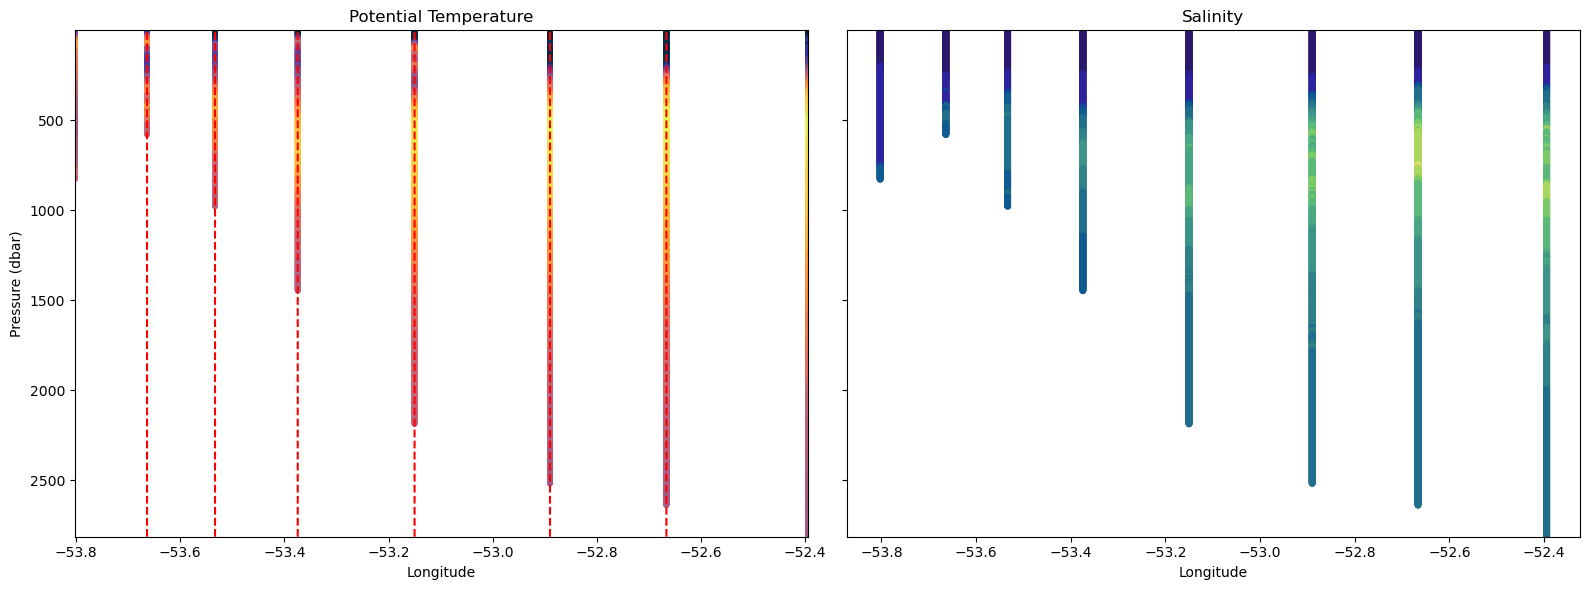

In [43]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: potential temperature
sc1 = ax1.scatter(long, p, c=Tpot, cmap='cmo.thermal', vmin=-1.75, vmax=0.65, s=10)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Potential Temperature')
ax1.contour(long_grid, p_grid, long_grid, levels=long_grid[0,:], colors='red')


#plot 2: salinity
bounds = [33.40, 34.50, 34.60, 34.61, 34.63, 34.65, 34.66, 34.67, 34.675, 34.68, 34.682, 34.684, 34.686, 34.688]
num_intervals = len(bounds)-1
cmap = plt.get_cmap('cmo.haline', num_intervals)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sc2 = ax2.scatter(long, p, c=Salinity, cmap=cmap, norm=norm, s=15)
ax2.set_xlabel('Longitude')
ax2.set_title('Salinity')

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

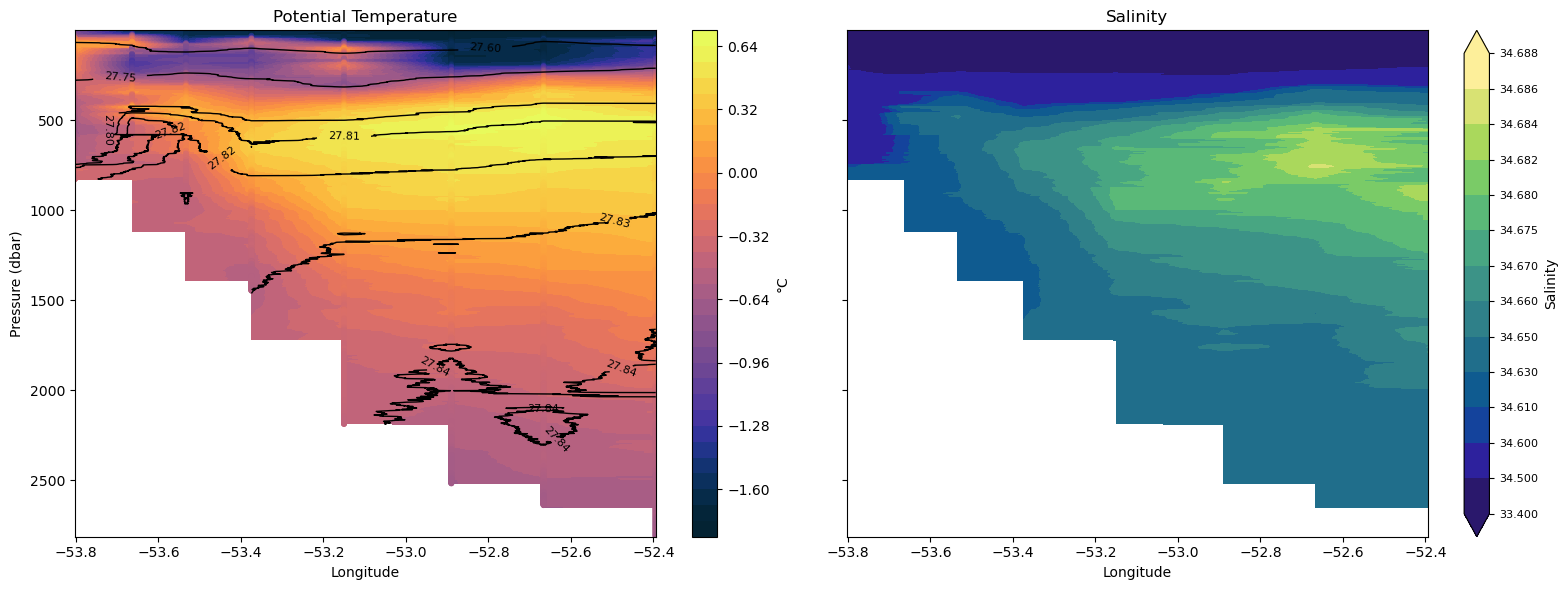

In [45]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: potential temperature
cntr1 = ax1.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.75, vmax=0.65)
sc1 = ax1.scatter(long, p, c=Tpot, cmap='cmo.thermal', vmin=-1.75, vmax=0.65, s=10)
#sc_1 = ax1.scatter(long[0:-1:100], p[0:-1:100], c=Tpot[0:-1:100], cmap='cmo.thermal', vmin=-1, vmax=0.6, edgecolors='k')
c1 = plt.colorbar(cntr1, ax=ax1)
c1.set_label('°C')

#density isolines
sigma_theta_bounds = [26.8, 27.6, 27.75, 27.80, 27.81, 27.82, 27.83, 27.84, 27.85]
intervals =len(sigma_theta_bounds)-1
contours1 = ax1.contour(long_grid, p_grid, grid_sigma_theta, levels=sigma_theta_bounds, colors='black', linewidths=1)
ax1.clabel(contours1, inline=True, fmt='%0.2f', fontsize=8)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Potential Temperature')


#plot 2: salinity
bounds = [33.40, 34.50, 34.60, 34.61, 34.63, 34.65, 34.66, 34.67, 34.675, 34.68, 34.682, 34.684, 34.686, 34.688]
num_intervals = len(bounds)-1

cmap = plt.get_cmap('cmo.haline', num_intervals)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cntr2 = ax2.contourf(long_grid, p_grid, grid_Salinity, levels=bounds, cmap=cmap, norm=norm, extend='both')

#sc2 = ax2.scatter(long, p, c=Salinity, cmap=cmap, norm=norm, s=15)
#0sc2 = ax2.scatter(long, p, cmap=cmap, norm=norm, s=15) TA
#sc_2 = ax2.scatter(long[0:-1:100], p[0:-1:100], c=Salinity[0:-1:100], cmap='cmo.haline', vmin=34.48, vmax=34.72, edgecolors='k')

cb2 = fig.colorbar(cntr2, ax=ax2, norm=norm, boundaries=bounds, ticks=bounds, label='Salinity')
cb2.ax.tick_params(labelsize=8)


ax2.set_xlabel('Longitude')
ax2.set_title('Salinity')

ax1.invert_yaxis()

plt.tight_layout()
plt.show()

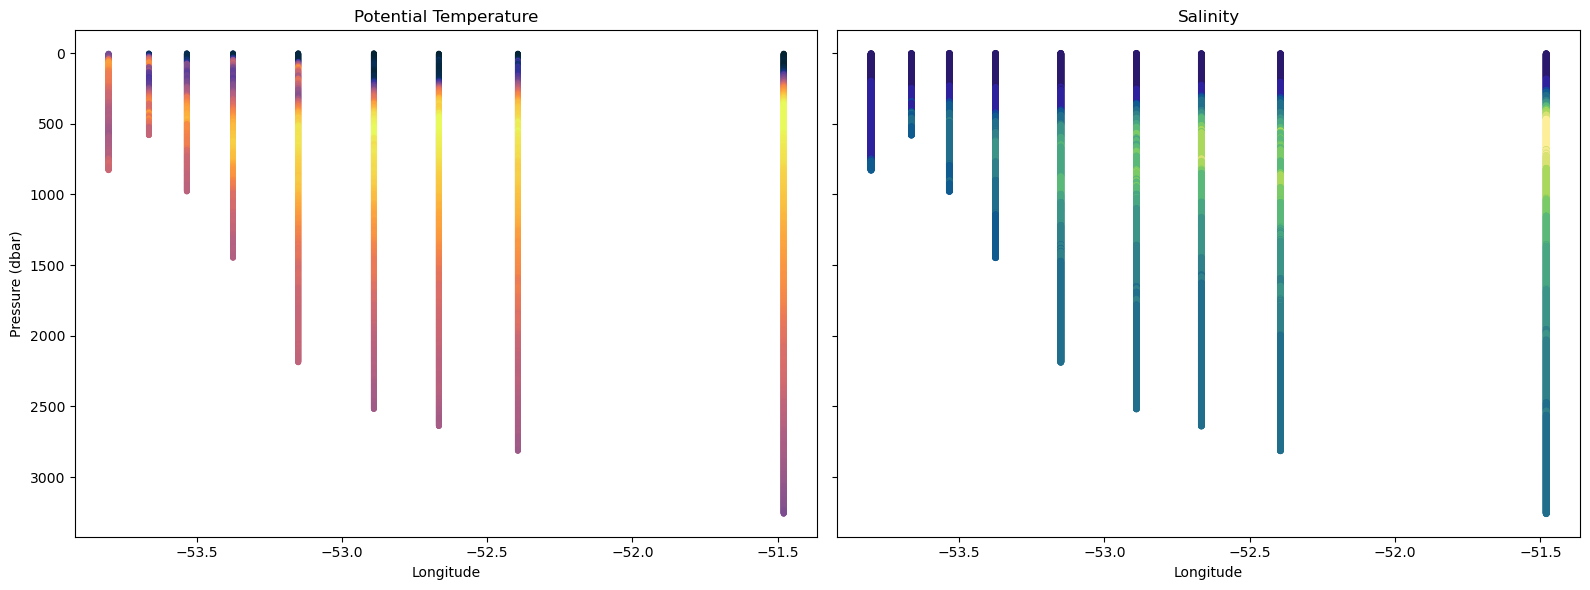

In [23]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: potential temperature
sc1 = ax1.scatter(long, p, c=Tpot, cmap='cmo.thermal', vmin=-1.75, vmax=0.65, s=10)
#sc_1 = ax1.scatter(long[0:-1:100], p[0:-1:100], c=Tpot[0:-1:100], cmap='cmo.thermal', vmin=-1, vmax=0.6, edgecolors='k')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Potential Temperature')


#plot 2: salinity
bounds = [33.40, 34.50, 34.60, 34.61, 34.63, 34.65, 34.66, 34.67, 34.675, 34.68, 34.682, 34.684, 34.686, 34.688]
num_intervals = len(bounds)-1

cmap = plt.get_cmap('cmo.haline', num_intervals)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


sc2 = ax2.scatter(long, p, c=Salinity, cmap=cmap, norm=norm, s=15)
#sc_2 = ax2.scatter(long[0:-1:100], p[0:-1:100], c=Salinity[0:-1:100], cmap='cmo.haline', vmin=34.48, vmax=34.72, edgecolors='k')


ax2.set_xlabel('Longitude')
ax2.set_title('Salinity')

ax1.invert_yaxis()

plt.tight_layout()
plt.show()

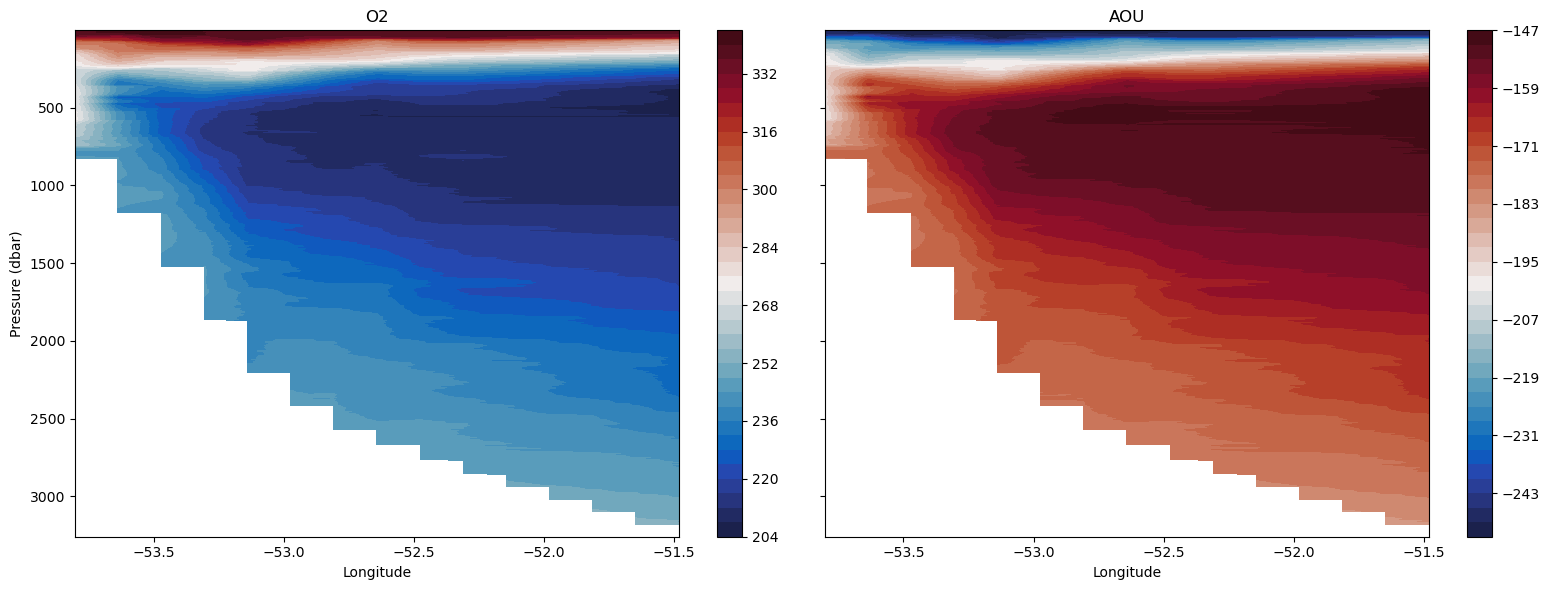

In [117]:
#O2, AOU
#meridional averaging
data_mer_av = data.groupby(['Pressure_dbar', 'Longitude'])[['O2', 'O2_sat', 'Sigma_theta']].mean().reset_index()

#extract variables
O2 = data_mer_av['O2'].values
O2_sat = data_mer_av['O2_sat'].values

AOU = (O2_sat - O2)

#interpolation in grid
grid_AOU = griddata((long, p), AOU, (long_grid, p_grid), method='linear')
grid_O2 = griddata((long, p), O2, (long_grid, p_grid), method='linear')


#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: O2
cntr1 = ax1.contourf(long_grid, p_grid, grid_O2, levels=35, cmap='cmo.balance')
c1 = plt.colorbar(cntr1, ax=ax1)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('O2')


#plot 2: AOU (apparent oxygen utilisation)
cntr2 = ax2.contourf(long_grid, p_grid, grid_AOU, levels=35, cmap='cmo.balance') 
c2 = plt.colorbar(cntr2, ax=ax2)

ax2.set_xlabel('Longitude')
ax2.set_title('AOU')

ax1.invert_yaxis()

plt.tight_layout()
plt.show()